Rolling cadence is slightly more complicated to configure, so this notebook will hopefully illustrate what is going on when one uses the rolling cadence basis functions.

In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.featureScheduler.modelObservatory import Model_observatory
import matplotlib.pylab as plt
import healpy as hp
import time
import lsst.sims.featureScheduler.basis_functions as bf
import lsst.sims.featureScheduler.surveys as surveys
%matplotlib inline

## Simple Rolling
For this first example, we will do a simple rolling cadence where we place an emphasis on the north in even years, and in the south on odd years.

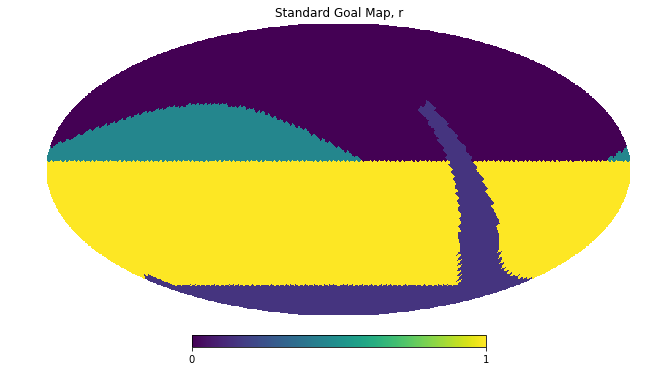

In [2]:
nside = 32
standard_goal_map = fs.utils.standard_goals(nside=nside)
hp.mollview(standard_goal_map['r'], title='Standard Goal Map, r')
# Here's the usual map we use, with the large WFD area, etc.

In [3]:
# For rolling cadence, we need to define 2 (or more) maps we want to use.

# Find where we want to divide the WFD area in half
wfd = standard_goal_map['r'] * 0
wfd[np.where(standard_goal_map['r'] == 1)] = 1
wfd_accum = np.cumsum(wfd)
split_indx = np.max(np.where(wfd_accum < wfd_accum.max()/2.))

indx = np.arange(standard_goal_map['r'].size)
top_half_wfd = np.where((standard_goal_map['r'] == 1) & (indx <= split_indx))
bottom_half_wfd = np.where((standard_goal_map['r'] == 1) & (indx > split_indx))

print('Healpixels in the North and South=', top_half_wfd[0].size, bottom_half_wfd[0].size)


Healpixels in the North and South= 2732 2733


In [4]:
# We need to define how much we want the rolling strength to be
up = 1.75
down = 0.25


In [5]:
# Now to define our even and odd years, and scale them:
even_year_target = fs.utils.standard_goals(nside=nside)
odd_year_target = fs.utils.standard_goals(nside=nside)
for filtername in even_year_target:
    even_year_target[filtername][top_half_wfd] *= up
    even_year_target[filtername][bottom_half_wfd] *= down

    odd_year_target[filtername][top_half_wfd] *= down
    odd_year_target[filtername][bottom_half_wfd] *= up


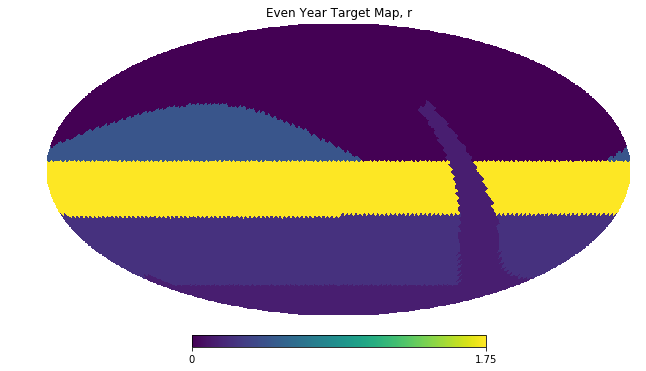

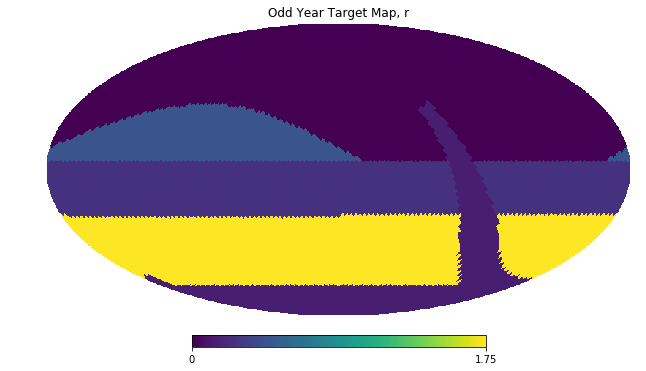

In [6]:
hp.mollview(even_year_target['r'], title='Even Year Target Map, r')
hp.mollview(odd_year_target['r'], title='Odd Year Target Map, r')

In [7]:
# Let's make a basis function that uses these two 
filtername = 'r'
# Still need to compute normalization factor
norm = fs.utils.calc_norm_factor(even_year_target)
mod_year = 2
target_list = [even_year_target[filtername], odd_year_target[filtername], standard_goal_map[filtername]]
tmbf=bf.Target_map_modulo_basis_function(filtername=filtername,
                                    target_maps=target_list,
                                    season_modulo=mod_year,
                                    out_of_bounds_val=np.nan, nside=nside,
                                    norm_factor=norm)

In [8]:
# Let's get a realistic conditions object
observatory = Model_observatory(nside=nside)
conditions = observatory.return_conditions()

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:377: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:437: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


In [10]:
# The basis function is zero until there have been observations taken (with zero 
# observations, nothing can be ahead or behind)

# Add an observation at ra,dec = 0,0. night=0. indx=0 means this observation only overlaps helpixel 0.
observation = fs.utils.empty_observation()
tmbf.add_observation(observation, indx=0)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


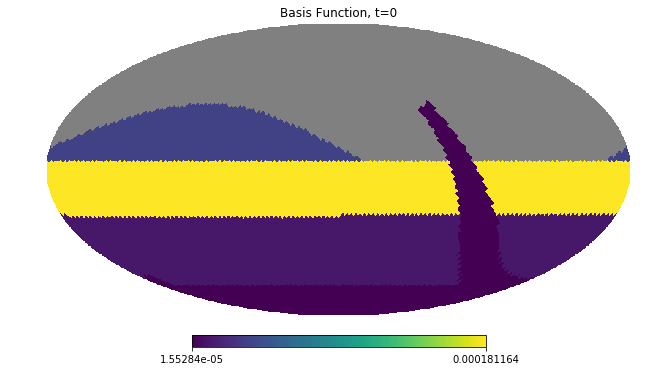

In [11]:
hp.mollview(tmbf(conditions), title='Basis Function, t=0')

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


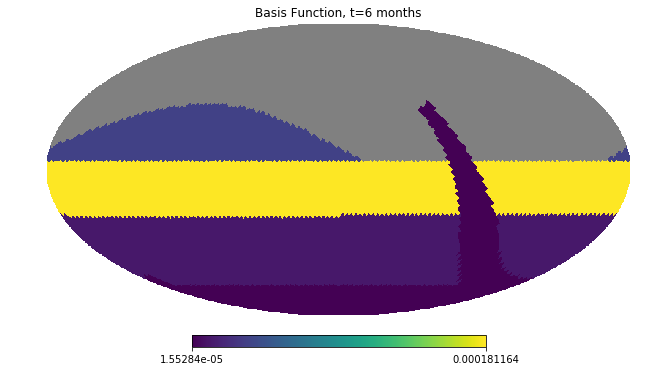

In [12]:
# Let's advance 6 months and see how it changes
conditions.night += 0.5*366
hp.mollview(tmbf(conditions), title='Basis Function, t=6 months')

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


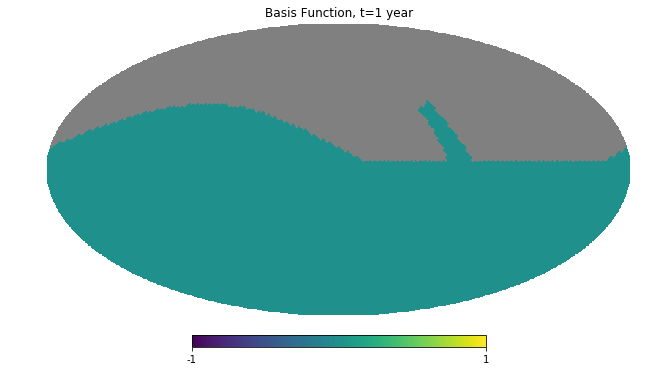

In [13]:
# And now 1 year after initial
conditions.night+= 0.5*366
hp.mollview(tmbf(conditions), title='Basis Function, t=1 year')

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


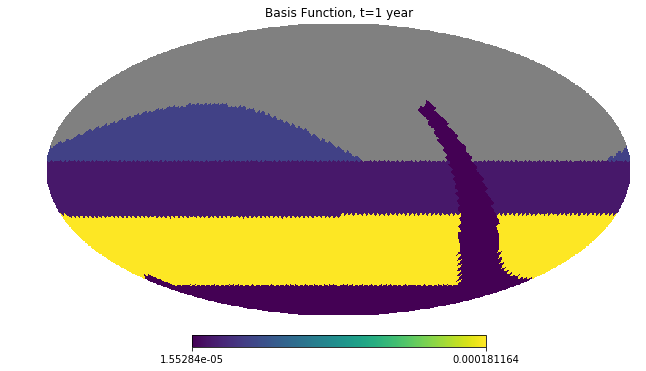

In [14]:
# This is what we expect, there haven't been any observations in this season yet. Let's take an observation:
observation['night'] = 366
tmbf.add_observation(observation, indx=0)
hp.mollview(tmbf(conditions), title='Basis Function, t=1 year')

That's the essence of simple rolling cadence--different target maps get used each year.

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


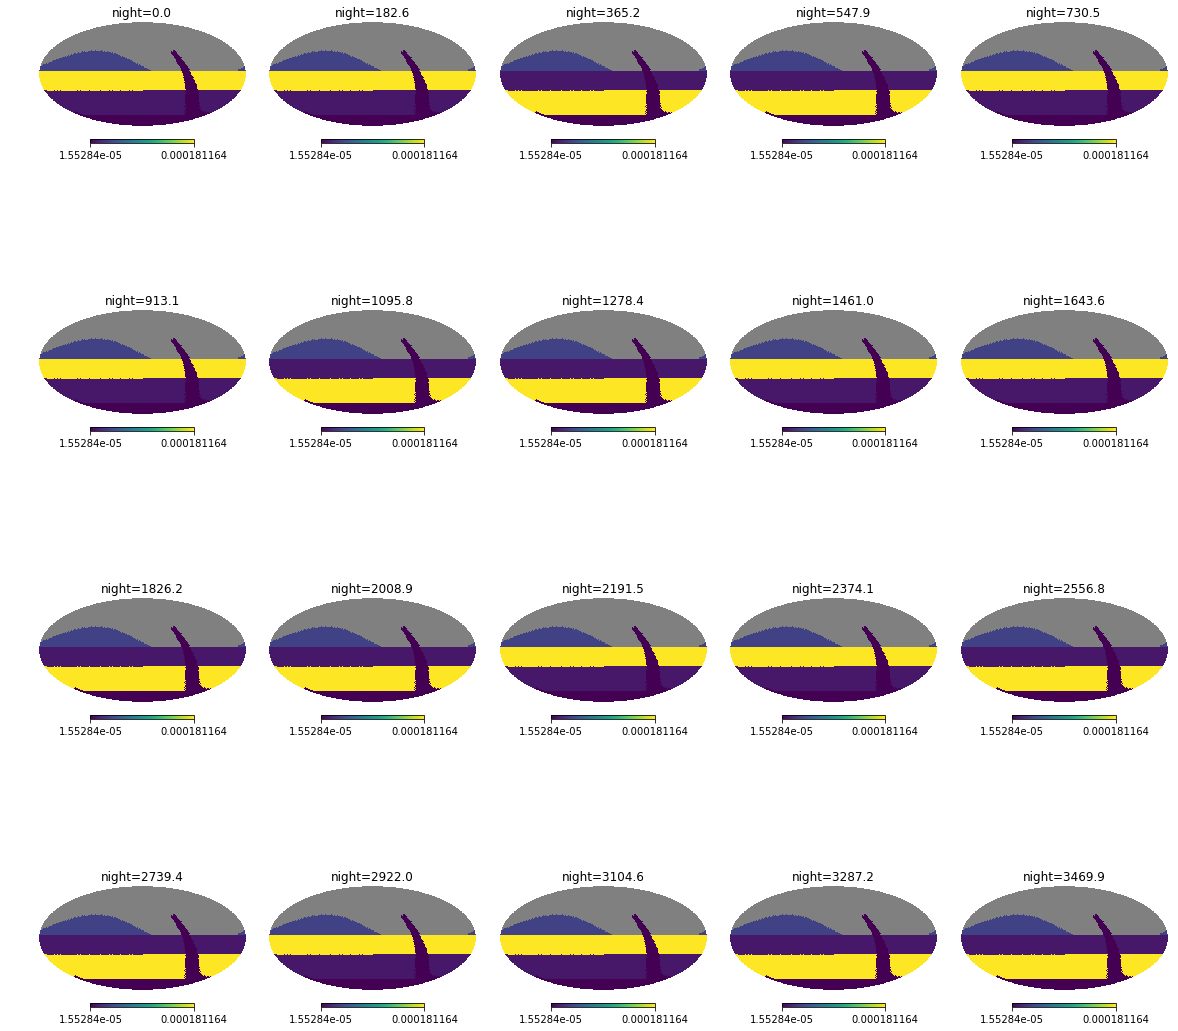

In [16]:
nights = np.arange(0,365.25*10, 365.25/2)
# Let's look at how the target map varies over time
i=0
fig = plt.figure(1, figsize=(16,16))
for night in nights:
    conditions.night = night
    i += 1
    hp.mollview(tmbf(conditions), title='night=%.1f' % night, sub=(4,5,i), fig=1)
   

## Rolling With Full Seasons

While that simple rolling works fine, there is an issue where some reagions will have rolling "on" during their entire observing season, while other regions will have inturrupted seasons. We might also like to have a uniform survey in the initial year.  Thus the basis function includes the option to offset the season calculation, as well as set a target map for seasons outside a given range

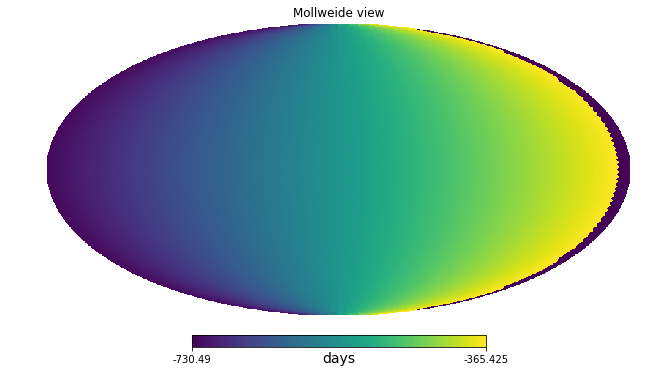

In [17]:
# Create an offset season map
sun_ra_0 = conditions.sunRA  # radians
offset = fs.utils.create_season_offset(nside, sun_ra_0)
hp.mollview(offset, unit='days')

In [18]:
# For our desired uniform year to start
zero_year_target = fs.utils.standard_goals(nside=nside)
# Set a maximum season when it should go back to uniform. Seasons start at 0 indexing
max_season = 6

In [19]:
target_list = [even_year_target[filtername], odd_year_target[filtername],
               zero_year_target[filtername]]
tmbf=bf.Target_map_modulo_basis_function(filtername=filtername,
                                                   target_maps=target_list,
                                                   season_modulo=mod_year, day_offset=offset,
                                                   out_of_bounds_val=np.nan, nside=nside,
                                                   norm_factor=norm,
                                                   max_season=max_season)

In [20]:
# Let's add a few observations to make sure each season has something observed
for night in nights:
    observation['night'] = night
    tmbf.add_observation(observation, indx=0)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


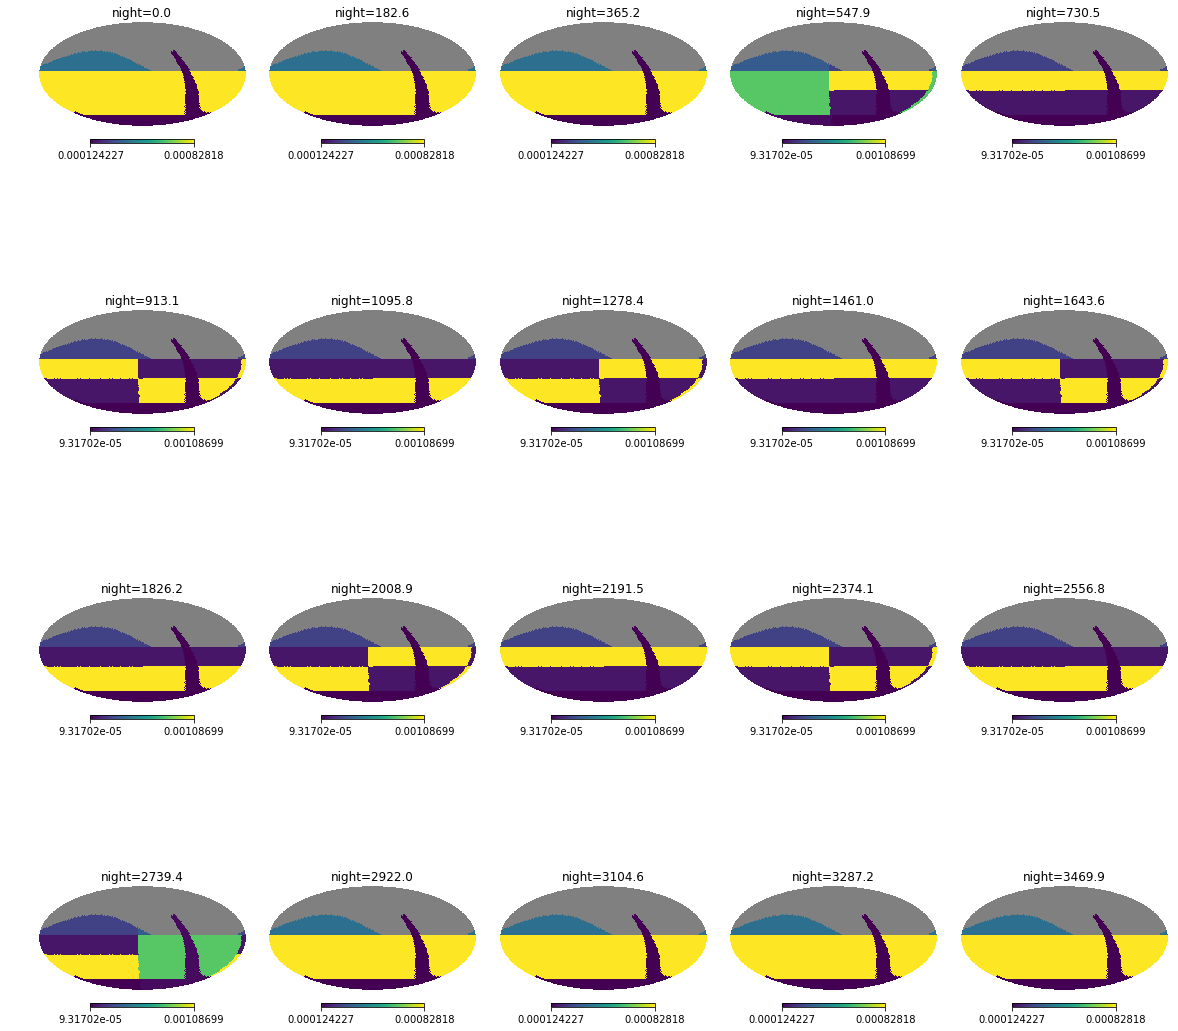

In [21]:
i=0
fig = plt.figure(1, figsize=(16,16))
for night in nights:
    conditions.night = night
    i += 1
    hp.mollview(tmbf(conditions), title='night=%.1f' % night, sub=(4,5,i), fig=1)
   

Now, rather than toggling maps on/off, different goal maps are spliced together, resulting in full seasons for all parts of the sky when the rolling emphasis is on. 